# context 

This script performs the final prediction using the LSTM model selected during the model‐selection phase. It also implements our chosen strategies by fetching fresh data directly from the API, making the script fully self‐contained and runnable at any time to have recent strategy.

# Imports

In [0]:
%pip install tensorflow

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.types import StructType, StructField, DateType, DoubleType, IntegerType
from pyspark.sql.functions import (
    col, to_date, lag, lead, avg, stddev, log, when, current_date,
    date_sub, add_months, expr, row_number, dayofweek, lit, desc, rand, udf
)

from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer, IndexToString
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from tensorflow.keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [0]:
symbol =  "AAPL"
api_key = "W2JH59HY3V94BMXQ"

In [0]:
def get_alpha_vantage_data(symbol, key):
    function = 'TIME_SERIES_DAILY'
    output_size = 'full'
    url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize={output_size}&apikey={key}'

    r = requests.get(url)
    data = r.json()

    if 'Time Series (Daily)' in data:
        df = pd.DataFrame(data['Time Series (Daily)']).T
        df.index = pd.to_datetime(df.index)
        df.sort_index(inplace=True)
        df.columns = [col.split('. ')[1] for col in df.columns]
        df = df.apply(pd.to_numeric)
        df = df[df.index >= datetime.now() - timedelta(days=365*20)]

        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Date'}, inplace=True)
        return spark.createDataFrame(df)
    else:
        raise Exception("Alpha Vantage API Error")

In [0]:
spark_df = get_alpha_vantage_data(symbol, api_key)

In [0]:
splits = {
    '2005-02-28': 2, # two-for-one stock split on 28 February 2005
    '2014-06-09': 7, #  seven-for-one stock split on 9th of June 2014
    '2020-08-31': 4. #  four-for-one stock split on 31st of August 2020
}

for split_date_str, stock_split in splits.items():
    split_date = datetime.strptime(split_date_str, "%Y-%m-%d")
    
    # Adjust prices before split date
    spark_df = spark_df.withColumn(
        'open',
        when(col('Date') < lit(split_date), col('open') / stock_split).otherwise(col('open'))
    ).withColumn(
        'high',
        when(col('Date') < lit(split_date), col('high') / stock_split).otherwise(col('high'))
    ).withColumn(
        'low',
        when(col('Date') < lit(split_date), col('low') / stock_split).otherwise(col('low'))
    ).withColumn(
        'close',
        when(col('Date') < lit(split_date), col('close') / stock_split).otherwise(col('close'))
    ).withColumn(
        'volume',
        when(col('Date') < lit(split_date), col('volume') * stock_split).otherwise(col('volume'))
    )



# Final Prediction

We use the LSTM model chosen during model selection. Because Spark ML doesn’t support LSTMs, we:

1. Convert the Spark DataFrame to pandas  
2. Run the LSTM predictions in pandas  
3. Convert the pandas results back into a Spark DataFrame  

**What’s changed**

- **Larger window size**  
  The model now looks further back in time to capture more variation.

- **Dropout layer**  
  Added dropout to improve generalization and reduce overfitting.

- **One-shot dense output**  
  A Dense layer predicts the entire forecast horizon at once, avoiding rolling forecasts.

 

In [0]:
window_size = 252  # 1 year of business days
horizon = 252      # forecast 1 year ahead

# Select relevant columns
spark_df = spark_df.select("date", "close", "open", "volume")
spark_df = spark_df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
training_pdf = spark_df.toPandas().sort_values("date")

# Scale all features together: close, open, volume
scaler = MinMaxScaler()
scaled_all = scaler.fit_transform(training_pdf[["close", "open", "volume"]].values) 

#  Create Sliding Windows 
X, Y = [], []
for i in range(len(scaled_all) - window_size - horizon + 1):
    X.append(scaled_all[i : i + window_size])  
    Y.append(scaled_all[i + window_size : i + window_size + horizon])  

X = np.array(X)  
Y = np.array(Y)  

#  Build LSTM Model 
model = Sequential([
    LSTM(64, input_shape=(window_size, 3)),
    Dropout(0.2),
    Dense(horizon * 3),
    Reshape((horizon, 3))  # output shape: (horizon, 3)
])

model.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError(name="rmse")])

# Train Model
history = model.fit(
    X, Y,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Forecast Next Business Year
last_window = scaled_all[-window_size:].reshape(1, window_size, 3)
pred_scaled = model.predict(last_window)[0]  
pred_prices = scaler.inverse_transform(pred_scaled)  

last_date = training_pdf["date"].iloc[-1]
future_dates = pd.bdate_range(start=last_date + BDay(1), periods=horizon)

Epoch 1/10
128/128 [==============================] - 18s 122ms/step - loss: 0.0097 - rmse: 0.0986 - val_loss: 0.0128 - val_rmse: 0.1133
Epoch 2/10
 26/128 [=====>........................] - ETA: 9s - loss: 0.0034 - rmse: 0.0583 

*** WARNING: max output size exceeded, skipping output. ***

128/128 [==============================] - 13s 105ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0180 - val_rmse: 0.1340
Epoch 10/10
1/1 [==============================] - 0s 407ms/step


INFO:tensorflow:Assets written to: /tmp/tmpz7910zrv/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpz7910zrv/model/data/model/assets


1/1 [==============================] - 0s 34ms/step


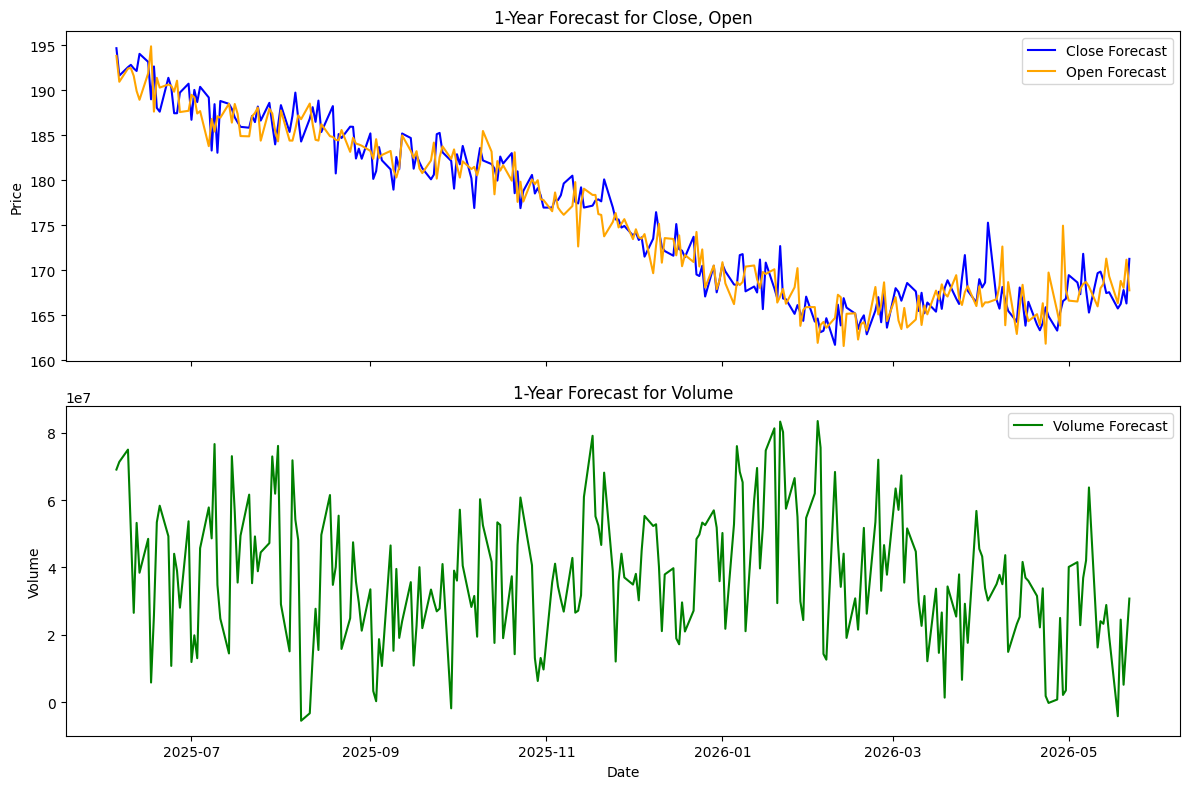

In [0]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Close & Open
ax1.plot(future_dates, pred_prices[:, 0], label="Close Forecast", color="blue")
ax1.plot(future_dates, pred_prices[:, 1], label="Open Forecast", color="orange")
ax1.set_ylabel("Price")
ax1.legend()
ax1.set_title("1-Year Forecast for Close, Open")

# Plot Volume
ax2.plot(future_dates, pred_prices[:, 2], label="Volume Forecast", color="green")
ax2.set_ylabel("Volume")
ax2.legend()
ax2.set_title("1-Year Forecast for Volume")
ax2.set_xlabel("Date")

plt.tight_layout()
plt.show()


In [0]:
# Step 1: Create a DataFrame from predictions
pred_df = pd.DataFrame(
    pred_prices, 
    columns=["close", "open", "volume"]
)
pred_df["date"] = future_dates

# Step 2: Concatenate with the original data
out = pd.concat([training_pdf, pred_df], ignore_index=True)

# Step 3: Convert to Spark DataFrame
spark_df = spark.createDataFrame(out)

# Step 4: View most recent forecast
from pyspark.sql.functions import desc
spark_df.orderBy(desc("date")).limit(20).orderBy("date").show()


+----------+------------------+------------------+-----------+
|      date|             close|              open|     volume|
+----------+------------------+------------------+-----------+
|2026-04-27|163.27688598632812|165.40872192382812|785286.1875|
|2026-04-28| 165.2696075439453|163.83453369140625|2.5006836E7|
|2026-04-29| 166.5552978515625|  174.940185546875| 2141050.75|
|2026-04-30|166.81297302246094| 167.7919464111328|  3493446.0|
|2026-05-01|169.44046020507812|166.60830688476562|4.0147808E7|
|2026-05-04|168.62709045410156| 166.5102996826172|4.1569336E7|
|2026-05-05| 167.3218231201172|167.90284729003906|2.2853606E7|
|2026-05-06|171.81109619140625| 168.4626007080078|3.6898096E7|
|2026-05-07| 167.7996826171875|168.67494201660156|4.2090996E7|
|2026-05-08|165.27833557128906|168.17860412597656|  6.37425E7|
|2026-05-11|  169.660888671875| 165.9709930419922|1.6236506E7|
|2026-05-12|169.83033752441406|167.98362731933594|2.4037812E7|
|2026-05-13|  168.881591796875|168.47512817382812|2.326

### Strategies Advice


In [0]:
# # Step 1: Set your known last historical date
# last_actual_date = training_pdf["date"].max()
# print(f"Last historical date: {last_actual_date}")

# # Step 2: Only use forecasted part
# forecast_df = spark_df.filter(col("date") > lit(last_actual_date))

# # Step 3: Define strategy offsets
# strategy_windows = {
#     "daily": 1,
#     "monthly": 21,
#     "quarterly": 63,
#     "yearly": 252
# }

# # Step 4: Count total number of forecasted rows
# forecast_count = forecast_df.count()

# # Step 5: Apply strategy logic on all forecast rows, best-effort
# for name, offset in strategy_windows.items():
#     actual_offset = min(offset, forecast_count - 1)  # limit offset to available rows

#     future_col = f"future_price_{name}"
#     return_col = f"return_{name}"
#     advice_col = f"{name}_advice"

#     # Add lead column
#     spark_df = spark_df.withColumn(future_col, lead("close", actual_offset).over(Window.orderBy("date")))

#     # Compute return
#     spark_df = spark_df.withColumn(
#         return_col,
#         ((col(future_col) - col("close")) / col("close")) * 100
#     )

#     # Thresholds
#     if name == "daily":
#         buy, sell = 2.5, -2.5
#     elif name == "monthly":
#         buy, sell = 5.0, -3.0
#     elif name == "quarterly":
#         buy, sell = 8.0, -5.0
#     elif name == "yearly":
#         buy, sell = 15.0, -10.0

#     # Advice only on predictions
#     spark_df = spark_df.withColumn(
#         advice_col,
#         when(col("date") > lit(last_actual_date),
#              when(col(return_col) >= buy, "Buy")
#              .when(col(return_col) <= sell, "Sell")
#              .otherwise("Hold")
#         )
#     )

# # Final selection: forecast only with advice
# advice_cols = ["date", "close"] + [f"{k}_advice" for k in strategy_windows]
# strategy_df = spark_df.select(*advice_cols).filter(col("date") > lit(last_actual_date))
# strategy_df.show(50, truncate=False)

### Predictions using the Decision Trees 

Create Target Labels (Buy / Sell / Hold). We simulate the label based on the next day’s return (as if we were simulating strategy).

We’ll simulate a basic trading strategy:
Start with an initial cash balance.
Buy: invest all cash into stock at current price.
Sell: sell all holdings at current price.
Hold: do nothing.
Track your total portfolio value (cash + stock).



Assumptions:
* You can only hold cash or stock at any time (no partial holdings).
* No trading fees for simplicity.
* Actions are taken on the same day as prediction (can be changed if needed).

In [0]:
#  Setup
spark_df = spark_df.withColumn("date", to_date(col("date")))
spark_df = spark_df.withColumn("close", col("close").cast("double"))
spark_df = spark_df.withColumn("open", col("open").cast("double"))
spark_df = spark_df.withColumn("volume", col("volume").cast("double"))

latest_actual_date = training_pdf["date"].max()

spark_df = spark_df.withColumn(
    "is_predicted",
    when(col("date") > lit(latest_actual_date), lit(1)).otherwise(lit(0))
)

#  Rolling Windows
w = Window.orderBy("date")
w7 = w.rowsBetween(-6, 0)
w21 = w.rowsBetween(-20, 0)
w30 = w.rowsBetween(-29, 0)

# Feature Engineering 
spark_df = spark_df.withColumn("prev_close", lag("close", 1).over(w))
spark_df = spark_df.withColumn("return", (col("close") - col("open")) / col("open"))
spark_df = spark_df.withColumn("log_return", log(col("close") / col("prev_close")))
spark_df = spark_df.withColumn("pred_return", (col("close") - col("prev_close")) / col("prev_close"))

spark_df = spark_df.withColumn("momentum_21d", avg("pred_return").over(w21))
spark_df = spark_df.withColumn("volatility_30", stddev("log_return").over(w30))
spark_df = spark_df.withColumn("ma_7", avg("close").over(w7))
spark_df = spark_df.withColumn("ma_30", avg("close").over(w30))
spark_df = spark_df.withColumn("volume_ma_7", avg("volume").over(w7))


# Features for 5-days forward return 
spark_df = spark_df.withColumn("future_close_5d", lead("close", 5).over(w))
spark_df = spark_df.withColumn("daily_return_5d", (col("future_close_5d") - col("close")) / col("close"))

spark_df = spark_df.withColumn("action",
    when(col("daily_return_5d") > 0.025, "Buy")
    .when(col("daily_return_5d") < -0.025, "Sell")
    .otherwise("Hold")
)

# Features for 21-days forward return 
spark_df = spark_df.withColumn("future_close_21d", lead("close", 21).over(w))
spark_df = spark_df.withColumn("daily_return_21d", (col("future_close_21d") - col("close")) / col("close"))

spark_df = spark_df.withColumn("action_month",
    when(col("daily_return_21d") > 0.05, "Buy")
    .when(col("daily_return_21d") < -0.03, "Sell")
    .otherwise("Hold")
)


## 5-days forward return 

In [0]:
features = ["pred_return",
            "momentum_21d", 
            "return", 
            # "log_return", # this one is removed becuase in feature importance it was the least important
            "volatility_30", 
            "ma_7", 
            "ma_30", 
            "volume_ma_7",
            ]

df_clean = spark_df.na.drop(subset=features + ["action"])

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_features = assembler.transform(df_clean)

indexer = StringIndexer(inputCol="action", outputCol="label")
df_labeled = indexer.fit(df_features).transform(df_features)

#  Train-Test Split
train_df = df_labeled.filter(col("is_predicted") == 0)
future_df = df_labeled.filter(col("is_predicted") == 1)

buy_df = train_df.filter(col("label") == 0)
sell_df = train_df.filter(col("label") == 1)
hold_df = train_df.filter(col("label") == 2)

# Balancing the dataset: sample all to the size of the smallest class
min_size = min(buy_df.count(), sell_df.count(), hold_df.count())

buy_df = buy_df.orderBy(rand()).limit(min_size)
sell_df = sell_df.orderBy(rand()).limit(min_size)
hold_df = hold_df.orderBy(rand()).limit(min_size)

balanced_train_df = buy_df.unionAll(sell_df).unionAll(hold_df)

In [0]:
# Running the RandomForestClassifier 

rf_best = RandomForestClassifier(
    numTrees=100,
    maxDepth=10,
    minInstancesPerNode=1,
    featureSubsetStrategy="auto",
    labelCol="label",
    featuresCol="features"
)

final_model = rf_best.fit(balanced_train_df)


In [0]:
train_predictions = final_model.transform(balanced_train_df)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print("Model Performance on Training Data:")
print("Accuracy:", evaluator.evaluate(train_predictions, {evaluator.metricName: "accuracy"}))
print("F1 Score:", evaluator.evaluate(train_predictions, {evaluator.metricName: "f1"}))
print("Precision:", evaluator.evaluate(train_predictions, {evaluator.metricName: "weightedPrecision"}))
print("Recall:", evaluator.evaluate(train_predictions, {evaluator.metricName: "weightedRecall"}))

Model Performance on Training Data:
Accuracy: 0.8619916746717899
F1 Score: 0.8630132647980732
Precision: 0.8704826072106266
Recall: 0.8619916746717898


In [0]:
confusion = train_predictions.groupBy("label", "prediction").count()
confusion.show()
print("Label mapping:", indexer.fit(df_features).labels)


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       1.0|   23|
|  0.0|       0.0|  939|
|  0.0|       2.0|   79|
|  1.0|       1.0|  849|
|  1.0|       0.0|  137|
|  1.0|       2.0|   55|
|  2.0|       0.0|  121|
|  2.0|       2.0|  904|
|  2.0|       1.0|   16|
+-----+----------+-----+

Label mapping: ['Hold', 'Buy', 'Sell']


In [0]:
for name, importance in zip(features, final_model.featureImportances):
    print(f"{name}: {importance:.4f}")

pred_return: 0.1451
momentum_21d: 0.1662
return: 0.1151
volatility_30: 0.1837
ma_7: 0.1177
ma_30: 0.1171
volume_ma_7: 0.1551


In [0]:
# Predict on Future Data with Probability Filtering 
predictions = final_model.transform(future_df)

# UDFs for extracting max probability and predicted label
get_max_prob = udf(lambda v: float(max(v)), DoubleType())
get_argmax = udf(lambda v: int(np.argmax(v)), IntegerType())

# Add max_prob and argmax_pred columns
predictions = predictions.withColumn("max_prob", get_max_prob(col("probability"))) \
                         .withColumn("argmax_pred", get_argmax(col("probability")))

# Apply filtering: keeping only confident predictions - 40% confidence
threshold = 0.4
filtered_predictions = predictions.filter(col("max_prob") >= threshold)

# Decode prediction back to label
label_decoder = IndexToString(inputCol="argmax_pred", outputCol="strategy_action",
                              labels=indexer.fit(df_features).labels)
filtered_predictions = label_decoder.transform(filtered_predictions)

In [0]:
predictions_pdf = filtered_predictions.select("date", "close", "strategy_action").orderBy("date").toPandas()


In [0]:
initial_cash = 1000
cash = initial_cash
stock = 0
portfolio_values = []

trade_log = []
entry_price = None  

for _, row in predictions_pdf.iterrows():
    price = row["close"]
    action = row["strategy_action"]
    
    if action == "Buy" and cash > 0:
        entry_price = price
        stock = cash / price
        cash = 0
        trade_log.append({"type": "Buy", "price": price, "date": row["date"]})

    elif action == "Sell" and stock > 0:
        profit = (price - entry_price) * stock if entry_price else 0
        cash = stock * price
        stock = 0
        trade_log.append({"type": "Sell", "price": price, "date": row["date"], "profit": profit})

    total_value = cash + stock * price
    portfolio_values.append(total_value)

# Assign portfolio values to DataFrame
predictions_pdf["portfolio_value"] = portfolio_values

# Create trade log DataFrame
import pandas as pd
trade_df = pd.DataFrame(trade_log)

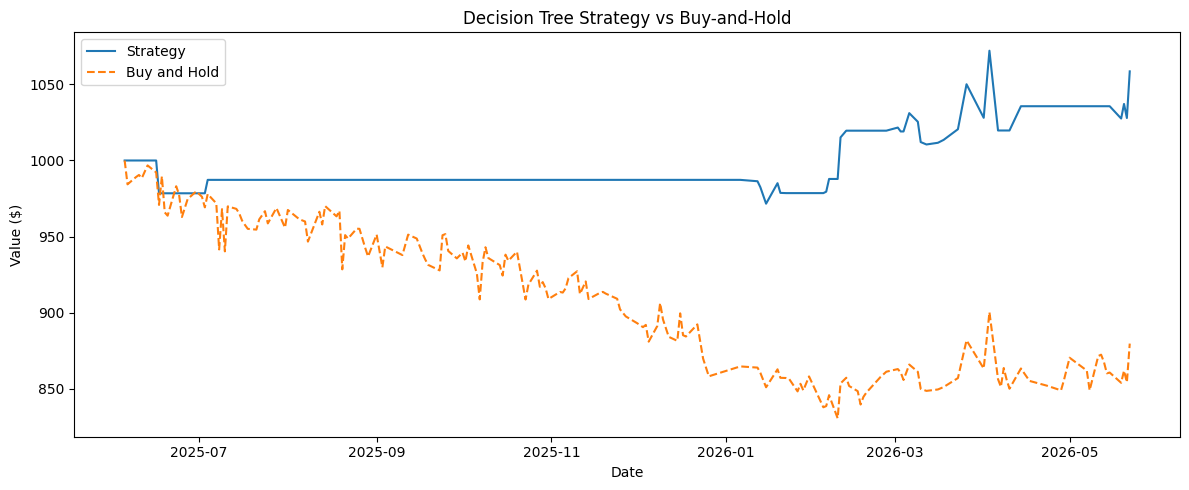

In [0]:
#  Buy-and-Hold Benchmark
initial_price = predictions_pdf["close"].iloc[0]
predictions_pdf["buy_and_hold"] = (initial_cash / initial_price) * predictions_pdf["close"]

plt.figure(figsize=(12, 5))
plt.plot(predictions_pdf["date"], predictions_pdf["portfolio_value"], label="Strategy")
plt.plot(predictions_pdf["date"], predictions_pdf["buy_and_hold"], label="Buy and Hold", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Value ($)")
plt.title("Decision Tree Strategy vs Buy-and-Hold")
plt.legend()
plt.tight_layout()
plt.show()


In [0]:
final_value = predictions_pdf["portfolio_value"].iloc[-1]
final_bnh = predictions_pdf["buy_and_hold"].iloc[-1]

print(f"Strategy Final Value: ${final_value:.2f}")
print(f"Buy & Hold Final Value: ${final_bnh:.2f}")
print(f"Strategy Outperformance: {((final_value / final_bnh) - 1) * 100:.2f}%")
num_sells = trade_df[trade_df["type"] == "Sell"].shape[0]
print(f"Trades Executed (sells): {num_sells}")


Strategy Final Value: $1058.55
Buy & Hold Final Value: $879.72
Strategy Outperformance: 20.33%
Trades Executed (sells): 8


In [0]:
print(trade_df)


    type       price        date     profit
0    Buy  193.143250  2025-06-16        NaN
1   Sell  188.982620  2025-06-17 -21.541676
2    Buy  188.670639  2025-07-03        NaN
3   Sell  190.370529  2025-07-04   8.815742
4    Buy  168.332077  2026-01-06        NaN
5   Sell  166.848648  2026-01-22  -8.700368
6    Buy  163.104553  2026-02-04        NaN
7   Sell  164.654358  2026-02-06   9.298319
8    Buy  161.690536  2026-02-09        NaN
9   Sell  166.882202  2026-02-12  31.719242
10   Buy  167.654968  2026-02-26        NaN
11  Sell  167.570236  2026-03-03  -0.515297
12   Buy  166.599365  2026-03-04        NaN
13  Sell  166.703247  2026-04-06   0.635437
14   Buy  165.479874  2026-04-10        NaN
15  Sell  168.066742  2026-04-14  15.940664
16   Buy  167.545059  2026-05-15        NaN


In [0]:
print(f"Predictions after filtering: {predictions_pdf.shape[0]}")


Predictions after filtering: 56


## Monthly

In [0]:

features = ["pred_return",
            "momentum_21d", 
            "return", 
            "log_return",
            "volatility_30", 
            "ma_7", 
            "ma_30", 
            "volume_ma_7",
            ]

df_clean = spark_df.na.drop(subset=features + ["action_month"])

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_features = assembler.transform(df_clean)

indexer = StringIndexer(inputCol="action", outputCol="label")
df_labeled = indexer.fit(df_features).transform(df_features)

#  Train-Test Split
train_df = df_labeled.filter(col("is_predicted") == 0)
future_df = df_labeled.filter(col("is_predicted") == 1)

buy_df = train_df.filter(col("label") == 0)
sell_df = train_df.filter(col("label") == 1)
hold_df = train_df.filter(col("label") == 2)

# Balancing the dataset: sample all to the size of the smallest class
min_size = min(buy_df.count(), sell_df.count(), hold_df.count())

buy_df = buy_df.orderBy(rand()).limit(min_size)
sell_df = sell_df.orderBy(rand()).limit(min_size)
hold_df = hold_df.orderBy(rand()).limit(min_size)

balanced_train_df = buy_df.unionAll(sell_df).unionAll(hold_df)

In [0]:
rf_best = RandomForestClassifier(
    numTrees=100,
    maxDepth=10,
    minInstancesPerNode=1,
    featureSubsetStrategy="auto",
    labelCol="label",
    featuresCol="features"
)

final_model = rf_best.fit(balanced_train_df)


In [0]:
train_predictions = final_model.transform(balanced_train_df)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print("Model Performance on Training Data:")
print("Accuracy:", evaluator.evaluate(train_predictions, {evaluator.metricName: "accuracy"}))
print("F1 Score:", evaluator.evaluate(train_predictions, {evaluator.metricName: "f1"}))
print("Precision:", evaluator.evaluate(train_predictions, {evaluator.metricName: "weightedPrecision"}))
print("Recall:", evaluator.evaluate(train_predictions, {evaluator.metricName: "weightedRecall"}))

Model Performance on Training Data:
Accuracy: 0.8645533141210374
F1 Score: 0.8655037410730251
Precision: 0.8695282782002269
Recall: 0.8645533141210375


In [0]:
confusion = train_predictions.groupBy("label", "prediction").count()
confusion.show()
print("Label mapping:", indexer.fit(df_features).labels)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       1.0|   36|
|  0.0|       0.0|  907|
|  0.0|       2.0|   98|
|  1.0|       1.0|  877|
|  1.0|       0.0|  123|
|  1.0|       2.0|   41|
|  2.0|       0.0|  109|
|  2.0|       2.0|  916|
|  2.0|       1.0|   16|
+-----+----------+-----+

Label mapping: ['Hold', 'Buy', 'Sell']


In [0]:
for name, importance in zip(features, final_model.featureImportances):
    print(f"{name}: {importance:.4f}")

pred_return: 0.1231
momentum_21d: 0.1575
return: 0.1020
log_return: 0.0718
volatility_30: 0.1702
ma_7: 0.1151
ma_30: 0.1133
volume_ma_7: 0.1469


In [0]:
# Predict on Future Data with Probability Filtering 
predictions = final_model.transform(future_df)

# UDFs for extracting max probability and predicted label
get_max_prob = udf(lambda v: float(max(v)), DoubleType())
get_argmax = udf(lambda v: int(np.argmax(v)), IntegerType())

# Add max_prob and argmax_pred columns
predictions = predictions.withColumn("max_prob", get_max_prob(col("probability"))) \
                         .withColumn("argmax_pred", get_argmax(col("probability")))

# Apply filtering: keeping only confident predictions - 40% confidence
threshold = 0.45
filtered_predictions = predictions.filter(col("max_prob") >= threshold)

# Decode prediction back to label
label_decoder = IndexToString(inputCol="argmax_pred", outputCol="strategy_action",
                              labels=indexer.fit(df_features).labels)
filtered_predictions = label_decoder.transform(filtered_predictions)

In [0]:
predictions_pdf = filtered_predictions.select("date", "close", "strategy_action").orderBy("date").toPandas()

initial_cash = 1000
cash = initial_cash
stock = 0
portfolio_values = []

trade_log = []
entry_price = None  

for _, row in predictions_pdf.iterrows():
    price = row["close"]
    action = row["strategy_action"]
    
    if action == "Buy" and cash > 0:
        entry_price = price
        stock = cash / price
        cash = 0
        trade_log.append({"type": "Buy", "price": price, "date": row["date"]})

    elif action == "Sell" and stock > 0:
        profit = (price - entry_price) * stock if entry_price else 0
        cash = stock * price
        stock = 0
        trade_log.append({"type": "Sell", "price": price, "date": row["date"], "profit": profit})

    total_value = cash + stock * price
    portfolio_values.append(total_value)

# Assign portfolio values to DataFrame
predictions_pdf["portfolio_value"] = portfolio_values

# Create trade log DataFrame
import pandas as pd
trade_df = pd.DataFrame(trade_log)

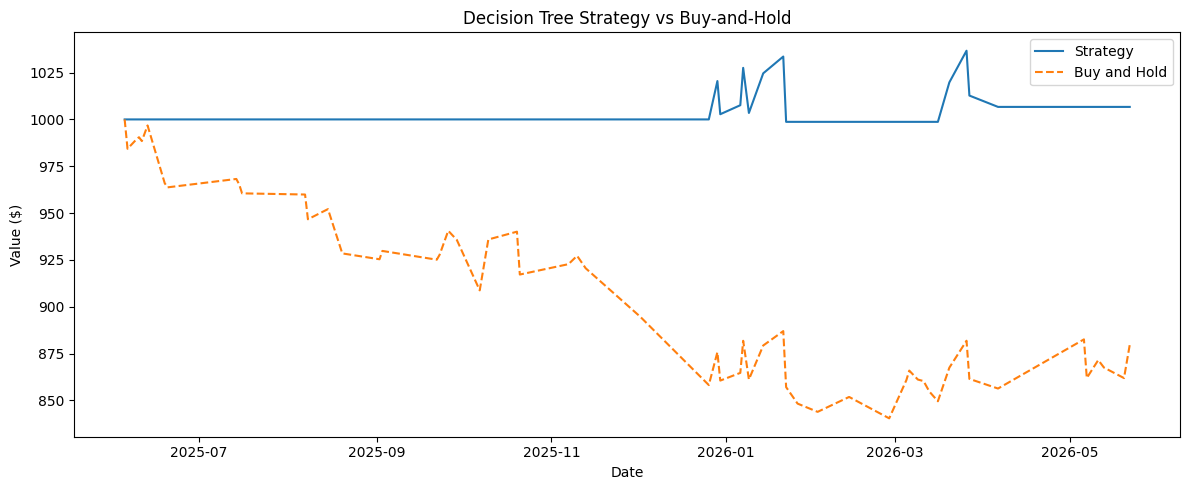

In [0]:
# Buy-and-Hold Benchmark 
initial_price = predictions_pdf["close"].iloc[0]
predictions_pdf["buy_and_hold"] = (initial_cash / initial_price) * predictions_pdf["close"]

# Plots
plt.figure(figsize=(12, 5))
plt.plot(predictions_pdf["date"], predictions_pdf["portfolio_value"], label="Strategy")
plt.plot(predictions_pdf["date"], predictions_pdf["buy_and_hold"], label="Buy and Hold", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Value ($)")
plt.title("Decision Tree Strategy vs Buy-and-Hold")
plt.legend()
plt.tight_layout()
plt.show()


In [0]:
final_value = predictions_pdf["portfolio_value"].iloc[-1]
final_bnh = predictions_pdf["buy_and_hold"].iloc[-1]

print(f"Strategy Final Value: ${final_value:.2f}")
print(f"Buy & Hold Final Value: ${final_bnh:.2f}")
print(f"Strategy Outperformance: {((final_value / final_bnh) - 1) * 100:.2f}%")
num_sells = trade_df[trade_df["type"] == "Sell"].shape[0]
print(f"Trades Executed (sells): {num_sells}")


Strategy Final Value: $1006.68
Buy & Hold Final Value: $879.72
Strategy Outperformance: 14.43%
Trades Executed (sells): 2


In [0]:
print(trade_df)

   type       price        date    profit
0   Buy  167.065262  2025-12-26       NaN
1  Sell  166.848648  2026-01-22 -1.296582
2   Buy  165.382568  2026-03-16       NaN
3  Sell  166.703247  2026-04-06  7.975244
